Run this code aftre this: : http://127.0.0.1:8888/lab/tree/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Get_data_for_modeing_1.ipynb

In this juper lab: 
1. load the project and one session 
2. load cells df
3. run the model on one session and load the shuffle data on one session
4. compare the r_original with the threshold calculated from the shuffle value (The shuffeling is ran on pc016)
5. Run the model for all the sessions in atLever_light and atLever_Dark and save the final df as a pkl file in result directory

In [351]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy import ndimage
from astropy.stats import circcorrcoef
from astropy import units as u
from functions import *
from lstmModel import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [347]:
%run ../../setup_project.py
%run ../../neuronAutopi.py

%run ../../generic_plot_functions.py

projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_inter",
                                                                dataPath="/adata/projects/autopi_inter/",dlcModelPath="/adata/models")


creating myProject, an autopipy.project object
Project name: autopi_inter
dataPath: /adata/projects/autopi_inter/
dlcModelPath: /adata/models
Reading /adata/projects/autopi_inter//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [348]:
#prepareSessionsForSpatialAnalysisProject(sSessions[:],myProject.sessionList[:]) ### sSeslist >>>> sSessions

prepareSessionsForSpatialAnalysisProject(sSessions[152:154],myProject.sessionList[152:154]) ### sSeslist >>>> sSessions
#prepareSessionsForSpatialAnalysisProject(sSessions[64:67],myProject.sessionList[64:67]) ### sSeslist >>>> sSessions

Loading Animal_pose and Spike_train, sSes.ap and sSes.cg
Will load .pose.npy


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.45s/it]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [349]:
#for ses, sSes in tqdm(zip(myProject.sessionList[:],sSessions[:])):
for ses, sSes in tqdm(zip(myProject.sessionList[152:154],sSessions[152:154])):
#for ses, sSes in tqdm(zip(myProject.sessionList[64:67],sSessions[64:67])):
    getSearchHomingIntervals(ses, sSes)

2it [00:00, 35.86it/s]


In [350]:
%%time

fn=myProject.dataPath+"/results/cells_with_leverCells.csv"
print('loading', fn)
cells = pd.read_csv(fn)

## load the levertime press 
fn ='behavior_180_v2.csv'
print('loading', fn)

res = pd.read_csv(fn)
###
df_HDInfoSingle = pd.read_csv('df_HDInfo.csv') 


loading /adata/projects/autopi_inter//results/cells_with_leverCells.csv
loading behavior_180_v2.csv
CPU times: user 163 ms, sys: 2.63 ms, total: 165 ms
Wall time: 165 ms


get the session index for sessions with more than 10 FS cells


In [357]:
filtered_cells = cells[(cells['interneuron']) & (cells['mrate_RF1'] > 10)]
session_counts = filtered_cells.groupby('session').size()

# Count how many sessions have more than one FS cell meeting the criteria
num_sessions = (session_counts >= 10).sum()
sessionList = session_counts[session_counts >= 10].index.tolist()
num_sessions 

sessionList[0]
Mylists=[]
for sesName in sessionList:
    Mylists.append([sSes.name for sSes in sSessions].index(sesName)) 

In [371]:
def run_evalute_model(sSes, ses, interName,cells, ctype='fs', sigma_ifr=5): 
    # Check if there are more than 1 FS cells in the session
    FS_count = cells[(cells.interneuron) & (cells.mrate_RF1 > 10) & (cells.session == sSes.name)].shape[0]
    if FS_count >= 1:
               
        train_dataset, test_dataset, train_data_loader, test_data_loader, myDict, config= get_test_training_datas_oneSession(sSes, ses, cells,interName, ctype= 'fs', sigma_ifr= 5, maxDistance= 18, rotationType="none")
        
        ### get my model 
        device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        model = LSTM(config["n_cells"], config["hidden_size"], config["num_layers"], config["num_outputs"],config["seq_length"],device=device).to(device)
        #print("Device available:", device)

        #optimizer = torch.optim.Adam(model.parameters(),lr=config["learning_rate"])
        optimizer = torch.optim.SGD(model.parameters(),lr=config["learning_rate"])
        loss_fn = torch.nn.MSELoss() # 
        model.train()


        ### train the model 
        df, best_model_state = training_loop(n_epochs=config["num_epochs"],
                     optimizer=optimizer,
                     model = model,
                     loss_fn = loss_fn,
                     train_data_loader=train_data_loader,
                     test_data_loader=test_data_loader, #changed to look at prediction in training dataset
                     config=config,
                     device = device,
                     verbose=False)
    
        mse_test, outputs_test, labels_test = get_labels_and_outputs_mse(model, test_data_loader, device)
        mse_train, outputs_train, labels_train = get_labels_and_outputs_mse(model, train_data_loader, device)

        myMetrics= {'session': sSes.name,
                   'df': df, 
                   'mse_test': mse_test, 
                   'outputs_test': outputs_test, 
                    'labels_test': labels_test, 
                    'mse_train': mse_train, 
                    'outputs_train': outputs_train,
                    'labels_train':labels_train,
                    'config': config
               }
        
    else:
        myMetrics=np.nan
    return myMetrics

def plot_summary_model_one_session(gs, sesName, df, Angle_test, Angle_test_pred, Angle_train, Angle_train_pred, shuffle, n_epochs, iteration ):
    
    #########################################
    ## plo the epochs and  test/training loss
    #########################################
    ax= fig.add_subplot(gs[0,0])
    ax.plot(df.epochs, df.train_loss, label= 'Train.')
    ax.plot(df.epochs, df.test_loss, label= 'Test')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc= 'center')
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss values')
    ax.set_title('{} \n epochs:{} ' .format(sesName, n_epochs), fontsize=9)
    ax.legend(loc='upper center', bbox_to_anchor=(0.9, 1.0), fancybox=True, shadow=True, fontsize=7)
    
    ##################################
    ## plot angle and pred. angle in test and training datasets:
    ###################################
    #Angle_test = np.arctan2(labels_test[:,0], labels_test[:,1])
    #Angle_test_pred = np.arctan2(outputs_test[:,0], outputs_test[:,1])
    
    ax= fig.add_subplot(gs[0,1])
    ax.scatter(Angle_train, Angle_train_pred, s= 0.1)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('predicted Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    r,p= pearsonr(Angle_train, Angle_train_pred)
    circr= abs(circcorrcoef(Angle_train, Angle_train_pred)) 
    ax.set_title('Train \n r:{:.2f} \n cir.r: {:.2f}'.format(r,circr ), fontsize=9)
    # plot the identity line
    ax.plot([min(Angle_train), max(Angle_train)], [min(Angle_train_pred), max(Angle_train_pred)], color='red', label=f'Iden. line')
    
    ax= fig.add_subplot(gs[0,2])
    ax.scatter(Angle_test, Angle_test_pred, s= 0.1)
    ax.set_xlabel('Angles ')##
    ax.set_ylabel('predicted Angles')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    r,p= pearsonr(Angle_test, Angle_test_pred)
    circr= abs(circcorrcoef(Angle_test, Angle_test_pred))
    ax.set_title('Test \n r:{:.2f}  \n cir.r: {:.2f}'.format(r, circr), fontsize=9)
    # plot the identity line
    ax.plot([min(Angle_test), max(Angle_test)], [min(Angle_test_pred), max(Angle_test_pred)], color='red', label=f'Iden. line')
    
    
    ## plot the model against the shuffle value 
    ax= fig.add_subplot(gs[0,3])
    ax.hist(shuffle.r_test)
    threshold= np.percentile(shuffle.r_test,95)
    ax.axvline(x=threshold, color='black', linestyle='--', linewidth=2, label='thr.')
    r_original,p= pearsonr(Angle_test, Angle_test_pred)
    ax.axvline(x=r_original, color='red', linestyle='-', linewidth=2, label='ori. r')
    ax.set_title(f'Test \n iteration:{iteration}, n_fs:{shuffle.df.iloc[0].n_cells.iloc[0]}', fontsize=9)
    ax.set_xlabel('Pearson r ')##
    ax.set_ylabel('Count')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='upper center', bbox_to_anchor=(1.7, 1.0), fancybox=True, shadow=True)
    
    #####################################################
    ### plot the 2d density plot for angle vs pred. angle 
    #####################################################

    ax= fig.add_subplot(gs[1,0])
    sns.kdeplot(x=Angle_test, y=Angle_test_pred, cmap="viridis", fill=True)
    ax.set_xlabel('Angles (pi)', fontsize=9)##
    ax.set_ylabel(' Predicted Angles (pi)', fontsize=9)##
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ###########
    ## check if i can get the location of the animal around the lever and compare it with the real location
    ###############
    x =  np.cos(Angle_test)
    y = np.sin(Angle_test)
    x_ =  np.cos(Angle_test_pred)
    y_ = np.sin(Angle_test_pred)

    ax= fig.add_subplot(gs[1,1])
    ax.scatter(x[10:50],y[10:50], s= 0.7, c= 'darkgray', label='data')
    ax.scatter(x_[10:50]+0.04,y_[10:50]+0.11, s= 0.8, c= 'red', label= 'predicted data')
    ax.axis('off')
    r,p= pearsonr(x, x_)
    ax.set_title(f'r:{r:.2f}, Ex.1', fontsize= 9)

    ax= fig.add_subplot(gs[1,2])
    ax.scatter(x[60:100],y[60:100], s= 0.7, c= 'darkgray', label='data')
    ax.scatter(x_[60:100]+0.04,y_[60:100]+0.11, s= 0.8, c= 'red', label= 'pred. data')
    ax.axis('off')
    r,p= pearsonr(x, x_)
    ax.set_title(f'r:{r:.2f}, Ex.2', fontsize= 9)
    
    ax= fig.add_subplot(gs[1,3])
    ax.scatter(x[110:150],y[110:150], s= 0.7, c= 'darkgray', label='data')
    ax.scatter(x_[110:150]+0.04,y_[110:150]+0.11, s= 0.8, c= 'red', label= 'pred. data')
    ax.axis('off')
    r,p= pearsonr(x, x_)
    ax.set_title(f'r:{r:.2f}, Ex.3', fontsize= 9)
    ax.legend(loc='upper center', bbox_to_anchor=(1.7, 1.0), fancybox=True, shadow=True)


In [370]:
ses= myProject.sessionList[152]
sSes= sSessions[152]

ctype= 'fs'
sigma_ifr= 5
interName= 'atLever_light'
## RUN THE MODEL
myMetrics = run_evalute_model(sSes, ses, interName,cells, ctype=ctype, sigma_ifr=sigma_ifr)


Plot some example from the model and compare it with shuffled value 

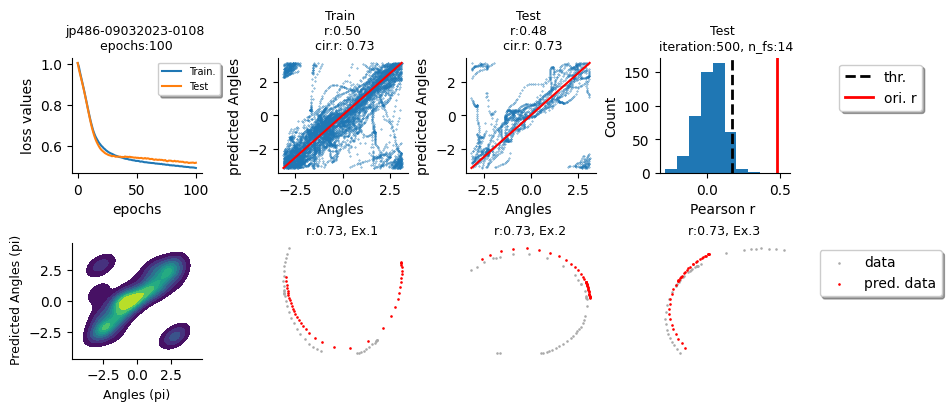

In [374]:
col = 6
row = 2
sizePerRow, sizePerCol = 2, 2
fig = plt.figure(figsize=(col * sizePerCol, row * sizePerRow), constrained_layout=True)
gs = gridspec.GridSpec(row, col, figure=fig, wspace=0)

shuffled_directory= '/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/500_shuffle/'
fn= f'{shuffled_directory}{sSes.name}_{interName}_shuffled_values.pkl'
shuffle= pd.read_pickle(fn)

Angle_train = np.arctan2(myMetrics['labels_train'][:,0], myMetrics['labels_train'][:,1])
Angle_train_pred = np.arctan2(myMetrics['outputs_train'][:,0], myMetrics['outputs_train'][:,1])

Angle_test = np.arctan2( myMetrics['labels_test'][:,0], myMetrics['labels_test'][:,1])
Angle_test_pred = np.arctan2(myMetrics['outputs_test'][:,0], myMetrics['outputs_test'][:,1])

plot_summary_model_one_session(gs,sSes.name, myMetrics['df'], Angle_test, Angle_test_pred, Angle_train, Angle_train_pred, shuffle, n_epochs= 100, iteration= 500 )

Run the model for all the sessions and save them in a df, for two intervals of:
1. atLever_light 
2. atLever_dark

## 1. atLever_light 


In [ ]:
all_Sessions = []  # Initialize an empty list to store metrics for each session
interName= 'atLever_light'
for sSes, ses in tqdm(zip(sSessions, myProject.sessionList)):  # Replace with your session objects and IDs
    myMetrics = run_evalute_model(sSes, ses, interName,cells, ctype=ctype, sigma_ifr=sigma_ifr)
    all_Sessions.append(myMetrics)  # Append each session’s results to the list


In [155]:
filtered_sessions = [item for item in all_Sessions if isinstance(item, dict) and item]
dfSessions = pd.DataFrame(filtered_sessions)

In [375]:
fn= '/home/maryam/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Sessions_model/allSessions_light.pkl'
#dfSessions.to_pickle(fn)
allSessions_light = pd.read_pickle(fn)

In [376]:
data=[]
for ind, row in allSessions_light.iterrows():
    
    df= row['df']
    ncells= df.n_cells
    Angle_train= np.arctan2(row['labels_train'][:,0], row['labels_train'][:,1])
    Angle_train_pred = np.arctan2(row['outputs_train'][:,0], row['outputs_train'][:,1])

    Angle_test = np.arctan2( row['labels_test'][:,0], row['labels_test'][:,1])
    Angle_test_pred = np.arctan2(row['outputs_test'][:,0], row['outputs_test'][:,1])
    
    r_test,p= pearsonr(Angle_test, Angle_test_pred)
    circr_test= abs(circcorrcoef(Angle_test, Angle_test_pred)) 
    
    r_train,p= pearsonr(Angle_train, Angle_train_pred)
    circr_train= abs(circcorrcoef(Angle_train, Angle_train_pred)) 

    MyData= {'session': row['session'],
             'interName': 'atLeverLight',
             'df': df,
             'nfs': ncells.iloc[0],
             'Angle_train': Angle_train,
             'Angle_train_pred': Angle_train_pred,
             'Angle_test': Angle_test,
             'Angle_test_pred': Angle_test_pred,
             'circr_test':circr_test,
             'circr_train': circr_train}
    
    data.append(MyData)

allSessions_df_light=pd.DataFrame(data)

In [381]:
#allSessions_df_light

## 2. atLever_Dark

In [ ]:
all_Sessions = []  # Initialize an empty list to store metrics for each session
interName= 'atLever_dark'
for sSes, ses in tqdm(zip(sSessions, myProject.sessionList)):  # Replace with your session objects and IDs
    myMetrics = run_evalute_model(sSes, ses, interName,cells, ctype=ctype, sigma_ifr=sigma_ifr)
    all_Sessions.append(myMetrics)  # Append each session’s results to the list


In [310]:
filtered_sessions = [item for item in all_Sessions if isinstance(item, dict) and item]
dfSessions_dark = pd.DataFrame(filtered_sessions)

Save or load the df

In [378]:
fn= '/home/maryam/repo/autopi_inter/autopi_interneuron_decoding/notebooks/Sessions_model/allSessions_dark.pkl'
#dfSessions_dark.to_pickle(fn)
dfSessions_dark = pd.read_pickle(fn)

In [379]:
data=[]
for ind, row in dfSessions_dark.iterrows():
    
    df= row['df']
    ncells= df.n_cells
    Angle_train= np.arctan2(row['labels_train'][:,0], row['labels_train'][:,1])
    Angle_train_pred = np.arctan2(row['outputs_train'][:,0], row['outputs_train'][:,1])

    Angle_test = np.arctan2( row['labels_test'][:,0], row['labels_test'][:,1])
    Angle_test_pred = np.arctan2(row['outputs_test'][:,0], row['outputs_test'][:,1])
    
    r_test,p= pearsonr(Angle_test, Angle_test_pred)
    circr_test= abs(circcorrcoef(Angle_test, Angle_test_pred)) 
    
    r_train,p= pearsonr(Angle_train, Angle_train_pred)
    circr_train= abs(circcorrcoef(Angle_train, Angle_train_pred)) 

    MyData= {'session': row['session'],
             'interName': 'atLeverdark',
             'df': df,
             'nfs': ncells.iloc[0],
             'Angle_train': Angle_train,
             'Angle_train_pred': Angle_train_pred,
             'Angle_test': Angle_test,
             'Angle_test_pred': Angle_test_pred,
             'circr_test':circr_test,
             'circr_train': circr_train}
    
    data.append(MyData)

allSessions_df_dark=pd.DataFrame(data)

In [382]:
#allSessions_df_dark

merge the two figure together and have a final figure:

In [383]:
allSessions_dfld= pd.concat([allSessions_df_dark, allSessions_df_light]).reset_index()
153*2, allSessions_dfld.shape


(306, (306, 11))

In [384]:
allSessions_dfld

,index,session,interName,df,nfs,Angle_train,Angle_train_pred,Angle_test,Angle_test_pred,circr_test,circr_train
0,0,mn8578-05122021-0108,atLeverdark,epochs seq_length n_cells hidden_size ...,1,"[-0.05478533, 0.062889285, -0.61021197, 0.3326...","[-2.7349052, -2.7820385, -2.9908197, 0.4766188...","[-0.7068635, -0.6536218, -0.6002408, -0.552762...","[1.0278932, 0.9996761, 0.97267467, 0.9453698, ...",0.044992,0.260336
1,1,mn8578-06122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,1,"[0.25866646, 0.22801594, -0.76026475, -2.09507...","[-0.70697856, 0.31739068, -0.5533314, 2.776596...","[1.807466, 1.7327834, 1.6672599, 1.6126592, 1....","[2.2410257, 2.2119594, 2.1725218, 2.1173813, 2...",0.257727,0.083148
2,2,mn8578-07122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,3,"[-0.5971179, -0.82600385, 3.0740168, -2.325464...","[-0.47369683, -0.6198919, -0.16575491, -0.3394...","[-1.1971694, -1.1859487, -1.1701932, -1.151709...","[-0.48683253, -0.4945706, -0.5108655, -0.53607...",0.451430,0.398826
3,3,mn8578-08122021-0110,atLeverdark,epochs seq_length n_cells hidden_size ...,3,"[-2.243688, 2.4231393, -0.092058904, 1.403623,...","[-1.5910472, -1.5272293, 0.27617824, -1.904884...","[-1.8811148, -1.875022, -1.8849323, -1.8888004...","[-1.3006667, -1.3319247, -1.3592049, -1.384517...",0.409319,0.351754
4,4,mn8578-10122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,4,"[-3.1203675, -2.197215, -2.547077, -1.2922583,...","[2.0808086, -2.5668118, -1.9384155, 2.8108375,...","[-2.2492583, -0.8869145, -0.85080755, -0.81858...","[1.9027859, 1.9401318, 1.98932, 2.038452, 2.07...",0.459914,0.583240
...,...,...,...,...,...,...,...,...,...,...,...
301,148,jp499-17052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,2,"[-2.2957647, -0.8533346, -1.5508065, 0.3979570...","[-1.6802485, -0.9772031, -0.5046469, -1.751059...","[-0.2496265, -0.2453315, -0.2399355, -0.234260...","[-1.5998276, -1.584808, -1.5617284, -1.5316858...",0.051345,0.137060
302,149,jp499-23052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,5,"[1.0758653, -0.19583806, -2.8547707, -0.229618...","[-0.697652, -0.6122384, -2.5940232, -0.2965195...","[-2.9092047, -2.9465926, -2.9934006, -3.039627...","[1.9315698, 1.8919411, 1.8581593, 1.8290914, 1...",0.187053,0.527122
303,150,jp499-24052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,9,"[-0.9410951, 0.54008853, 0.5556197, 0.53921527...","[-0.983582, -0.7370983, -0.74676526, 2.9604454...","[-0.20676759, -0.24085288, -0.2837893, -0.3364...","[-0.20530808, -0.15750234, -0.10203931, -0.043...",0.453954,0.532624
304,151,jp499-18052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,4,"[-2.7955167, 2.3539667, -2.4371078, -1.4491835...","[-1.6691586, 0.3915908, -1.2496557, -1.6503128...","[-0.7562389, -0.7241915, -0.64755017, -0.59298...","[-0.3755715, -0.41182712, -0.508096, -0.663541...",0.008717,0.298438


1. add the r for each test and training sets and save them as a cew column 
2. save the final df in the result directory in the /adata/electro 

In [385]:
# Define a function to calculate Pearson correlation
def calculate_r_test(row):
    r, _ = pearsonr(row['Angle_test'], row['Angle_test_pred'])
    return r

def calculate_r_train(row):
    r, _ = pearsonr(row['Angle_train'], row['Angle_train_pred'])
    return r

# Apply the functions to the DataFrame
allSessions_dfld['r_test'] = allSessions_dfld.apply(calculate_r_test, axis=1)
allSessions_dfld['r_train'] = allSessions_dfld.apply(calculate_r_train, axis=1)

In [386]:
fn= '/adata/projects/autopi_inter/results/interneurons_decoding_angleAroundlever/allSessions_dfld.pkl'
allSessions_dfld.to_pickle(fn)

In [387]:
ses.intervalDict.keys(), allSessions_dfld.keys(), allSessions_dfld.interName.unique()

(dict_keys(['circ80', 'circ80_1', 'circ80_2', 'task', 'task_1', 'task_2', 'light', 'light_1', 'light_2', 'dark', 'dark_1', 'dark_2', 'trialNo', 'searchPath_light', 'searchPath_light_1', 'searchPath_light_2', 'searchPath_dark', 'searchPath_dark_1', 'searchPath_dark_2', 'searchToLeverPath_light', 'searchToLeverPath_light_1', 'searchToLeverPath_light_2', 'searchToLeverPath_dark', 'searchToLeverPath_dark_1', 'searchToLeverPath_dark_2', 'homingPath_light', 'homingPath_light_1', 'homingPath_light_2', 'homingPath_dark', 'homingPath_dark_1', 'homingPath_dark_2', 'homingFromLeavingLever_light', 'homingFromLeavingLever_light_1', 'homingFromLeavingLever_light_2', 'homingFromLeavingLever_dark', 'homingFromLeavingLever_dark_1', 'homingFromLeavingLever_dark_2', 'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_light_1', 'homingFromLeavingLeverToPeriphery_light_2', 'homingFromLeavingLeverToPeriphery_dark', 'homingFromLeavingLeverToPeriphery_dark_1', 'homingFromLeavingLever

In [388]:
allSessions_dfld

,index,session,interName,df,nfs,Angle_train,Angle_train_pred,Angle_test,Angle_test_pred,circr_test,circr_train,r_test,r_train
0,0,mn8578-05122021-0108,atLeverdark,epochs seq_length n_cells hidden_size ...,1,"[-0.05478533, 0.062889285, -0.61021197, 0.3326...","[-2.7349052, -2.7820385, -2.9908197, 0.4766188...","[-0.7068635, -0.6536218, -0.6002408, -0.552762...","[1.0278932, 0.9996761, 0.97267467, 0.9453698, ...",0.044992,0.260336,-0.286297,0.157174
1,1,mn8578-06122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,1,"[0.25866646, 0.22801594, -0.76026475, -2.09507...","[-0.70697856, 0.31739068, -0.5533314, 2.776596...","[1.807466, 1.7327834, 1.6672599, 1.6126592, 1....","[2.2410257, 2.2119594, 2.1725218, 2.1173813, 2...",0.257727,0.083148,0.158053,0.185566
2,2,mn8578-07122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,3,"[-0.5971179, -0.82600385, 3.0740168, -2.325464...","[-0.47369683, -0.6198919, -0.16575491, -0.3394...","[-1.1971694, -1.1859487, -1.1701932, -1.151709...","[-0.48683253, -0.4945706, -0.5108655, -0.53607...",0.451430,0.398826,0.158318,0.232374
3,3,mn8578-08122021-0110,atLeverdark,epochs seq_length n_cells hidden_size ...,3,"[-2.243688, 2.4231393, -0.092058904, 1.403623,...","[-1.5910472, -1.5272293, 0.27617824, -1.904884...","[-1.8811148, -1.875022, -1.8849323, -1.8888004...","[-1.3006667, -1.3319247, -1.3592049, -1.384517...",0.409319,0.351754,0.402051,0.213557
4,4,mn8578-10122021-0107,atLeverdark,epochs seq_length n_cells hidden_size ...,4,"[-3.1203675, -2.197215, -2.547077, -1.2922583,...","[2.0808086, -2.5668118, -1.9384155, 2.8108375,...","[-2.2492583, -0.8869145, -0.85080755, -0.81858...","[1.9027859, 1.9401318, 1.98932, 2.038452, 2.07...",0.459914,0.583240,0.501421,0.474051
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,148,jp499-17052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,2,"[-2.2957647, -0.8533346, -1.5508065, 0.3979570...","[-1.6802485, -0.9772031, -0.5046469, -1.751059...","[-0.2496265, -0.2453315, -0.2399355, -0.234260...","[-1.5998276, -1.584808, -1.5617284, -1.5316858...",0.051345,0.137060,-0.124892,0.061712
302,149,jp499-23052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,5,"[1.0758653, -0.19583806, -2.8547707, -0.229618...","[-0.697652, -0.6122384, -2.5940232, -0.2965195...","[-2.9092047, -2.9465926, -2.9934006, -3.039627...","[1.9315698, 1.8919411, 1.8581593, 1.8290914, 1...",0.187053,0.527122,0.397254,0.410371
303,150,jp499-24052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,9,"[-0.9410951, 0.54008853, 0.5556197, 0.53921527...","[-0.983582, -0.7370983, -0.74676526, 2.9604454...","[-0.20676759, -0.24085288, -0.2837893, -0.3364...","[-0.20530808, -0.15750234, -0.10203931, -0.043...",0.453954,0.532624,0.438679,0.412614
304,151,jp499-18052023-0108,atLeverLight,epochs seq_length n_cells hidden_size ...,4,"[-2.7955167, 2.3539667, -2.4371078, -1.4491835...","[-1.6691586, 0.3915908, -1.2496557, -1.6503128...","[-0.7562389, -0.7241915, -0.64755017, -0.59298...","[-0.3755715, -0.41182712, -0.508096, -0.663541...",0.008717,0.298438,0.249851,0.257661
